<font size="8">Build an ANUGA Model (BAM) </font>

<font size="3">In this notebook, we will:

- 



</font>

<font size="3">This could take some time, depending on model domain size and complexity of the water mask</font>


<font size=5 color='green'> If you are running in Google Colab, set the variable yes_colab = True.</font> <br>
<font size=5 color='blue'> If you are running on your own computer, set the variable yes_colab = False </font>


In [1]:
yes_colab = False


<font size=6> Step #1a: Set working directory <br> </font>



<font size=5 color='green'> If you are running in Google Colab, when you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>



In [2]:
import os
import sys
from pathlib import Path

your_path = Path(os.getcwd() + '/')
if yes_colab:
    where_to_mount = '/content/drive/'
    from google.colab import drive
    drive.mount(where_to_mount, force_remount=True)
    mounted_drive = Path(where_to_mount) / 'MyDrive' 
    sys.path.append(str(mounted_drive / 'installations'))
    path_ancillary = mounted_drive / 'ancillary'
    Path(mounted_drive / 'installations').mkdir(parents=True, exist_ok=True)

else:
    mounted_drive = Path(os.path.abspath(os.path.join(your_path, os.pardir)))

print('Your working directory is %s' %(mounted_drive))



Your working directory is /Users/alchrist/Documents/GitHub/BAM


<font size=6> Step #1b: Install and import packages. <font> <br>

<font size=5 color='green'> If you are running in Google Colab, this cell should install all Python packages you need for each tutorial. </font> <br>
<font size=5 color='blue'> If you are running on your own computer, the packages were already installed when you installed the conda environment </font>


In [3]:
import os
os.chdir(mounted_drive)
if yes_colab:
  if os.path.isdir(mounted_drive / 'BAM'):
    print('## Updating the local git repository \n')
    os.chdir(mounted_drive / 'BAM')
    #!git fsck --full
    # !git add -A 
    !git stash   
    !git pull
    # !rm -rf {mounted_drive/'BAM'}

  else:
    print('## Pulling the git repository with files for the tutorial\n')
    !git clone https://github.com/achri19/BAM.git


In [4]:
if yes_colab:
  print('\n## Installing the Python packages needed for these tutorials\n')
  try:
    import geopandas as gpd
  except:
    !/bin/bash $mounted_drive/BAM/notebooks/install_packages_colab_debug.sh


In [5]:
path_ancillary = mounted_drive / 'ancillary'
path_code = mounted_drive / 'scripts/'
path_templates = mounted_drive /  'templates/'
path_configs = mounted_drive / 'configs/'
sys.path.insert(1,str(path_code))
print(path_code)
print(path_ancillary)

path_examples = mounted_drive / 'examples'
path_examples.mkdir(parents=True, exist_ok=True)

/Users/alchrist/Documents/GitHub/BAM/scripts
/Users/alchrist/Documents/GitHub/BAM/ancillary


In [6]:
sys.path

['/Users/alchrist/anaconda3/envs/BAM_dev/lib/python310.zip',
 '/Users/alchrist/Documents/GitHub/BAM/scripts',
 '/Users/alchrist/anaconda3/envs/BAM_dev/lib/python3.10',
 '/Users/alchrist/anaconda3/envs/BAM_dev/lib/python3.10/lib-dynload',
 '',
 '/Users/alchrist/anaconda3/envs/BAM_dev/lib/python3.10/site-packages']

In [7]:
import sys
import os
import pandas as pd
import shutil
from datetime import datetime
from string import Template
import fnmatch
import geopandas as gpd
import rasterio
from osgeo import gdal 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rtree
from scipy import *

## ANUGA packages
import anuga
from anuga.utilities.plot_utils import Make_Geotif
from anuga.coordinate_transforms.geo_reference import Geo_reference
from anuga.utilities import animate
from anuga import myid, numprocs, finalize, barrier
from anuga.parallel.parallel_inlet_operator import Parallel_Inlet_operator


In [8]:
try:
  import pyTMD
except:
  !pip install pytmd

from main_tools import (build_directory,
                       get_extent_parameters,
                       setup_AOI_files, 
                       make_polygons,
                       make_channel_networks,
                       make_model_foundation, 
                       set_boundary_conditions, 
                       make_watermask,
                       more_opening)
from BYOM_extra import make_mesh_polygons, determine_riverscale
from polygon_tools import getpolygonpoints, removenearbypoints, delete_holes
from Boundary_Tools import(set_boundary_conditions, 
                           get_inlet, 
                           get_tidal_boundary, 
                           get_tide_data_pytmd)


# Standard packages

import fnmatch
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point, LineString
## Plotting modules
import matplotlib.pyplot as plt

## Google Earth Packages
import ee
from ee import batch
# import geemap

import zipfile



/Users/alchrist/Documents/GitHub/BAM/scripts/orinoco_tools.py:42: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/Users/alchrist/Documents/GitHub/BAM/scripts/orinoco_tools.py:43: UserWarning: UserWarning
  warnings.warn('UserWarning')
/Users/alchrist/Documents/GitHub/BAM/scripts/BYOM_extra.py:15: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/Users/alchrist/Documents/GitHub/BAM/scripts/BYOM_extra.py:16: UserWarning: UserWarning
  warnings.warn('UserWarning')


<font size=6> Step #1c: Choose to run the Demo or set up your own AOI. If running demo, unzip example files in Komo.zip <font> 




In [9]:
demo = False
if demo:
    with zipfile.ZipFile("komo_starter.zip", 'r') as zip_ref:
        zip_ref.extractall(path_examples)
    AOI = 'komo'
else:
    AOI = 'magdalena'

<font size=6, color ='black' > Step #2: Set the AOI and working directory  </font>


AOI should match the name of the folder where files will be saved

In [10]:


Path((path_examples / AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 10 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(path_examples, AOI)
working_path = Path(working_path)
print(working_path)


elev_name = 'Elevation_ocean-GEBCO_land-GLO30_rivers-wdpower_wetland-uni0m_lakes-uni1m_adj'



Study area is magdalena
Resolution of this setup is 10m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Users/alchrist/Documents/GitHub/BAM/examples/magdalena
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 

In [11]:
path_working,folders = build_directory(path_examples, AOI)

parameters = pd.read_csv('%s/%s_Configuration.csv' %(folders[2],AOI))
EPSG            = int(parameters['EPSG'][0])                         # Coordinate system






##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Users/alchrist/Documents/GitHub/BAM/examples/magdalena
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
##################### 8 Setup_Files/Setup_RST --> Rasters

In [12]:
try:
    ref = rasterio.open('%s/%s_GEBCO_%s.tif' %(folders[8],AOI,res))
except:
    os.system('gdalwarp -overwrite -tr %s %s %s%s_GEBCO_%s.tif %s%s_GEBCO_%s.tif '\
              ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
              %(xres,yres,folders[8],AOI,ref_res,folders[8],AOI,xres,ulx,lry,lrx,uly))
    ref = rasterio.open('%s%s_GEBCO_%s.tif' %(folders[8],AOI,res))
    
ref_profile = ref.profile


In [13]:
model_domain = gpd.read_file('%s/%s_input.shp' %(folders[0],AOI))
model_domain.crs = 4326
domain_name = ''
Path(domain_name).mkdir(parents=True, exist_ok=True)

try:
    tide_bnd = gpd.read_file('%s/%s_tidebnd.shp' %(folders[0],AOI))
    tide_bnd.to_file('%s/%s_tidebnd.shp' %(folders[3],AOI))
    print('Tidal boundary is defined by User File (%s_tidebnd.shp)' %(AOI))

except:
    print('Tidal boundary is not defined yet, choosen random side as tides! Top')
    # left,top,right,bottom = model_domain.total_bounds
    # tide_bnd = gpd.GeoDataFrame({'id':['1']},geometry =  [LineString([Point(left,top), Point(right,top)])])
    # tide_bnd.crs =model_domain.crs
    # tide_bnd.to_file('%s/%s_tidebnd.shp' %(folders[3],AOI))

#     tide_bnd_EPSG = []
#     tideLAT_EPSG = -9999
#     tideLON_EPSG = -9999


if tide_bnd.crs != 'EPSG:4326':
    tide_bnd = tide_bnd.to_crs('EPSG:4326')    
tide_centroid = tide_bnd.centroid

tide_bnd_EPSG = tide_bnd.to_crs('EPSG:%s' %(EPSG))
tide_EPSG_centroid = tide_bnd_EPSG.centroid

tideLAT_EPSG = round(tide_EPSG_centroid.geometry[0].coords.xy[1][0],2)
tideLON_EPSG = round(tide_EPSG_centroid.geometry[0].coords.xy[0][0],2)



Tidal boundary is defined by User File (magdalena_tidebnd.shp)


/var/folders/29/4c92_fhn3_g9d625mvc8mrth0000gq/T/ipykernel_37933/2571246301.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tide_centroid = tide_bnd.centroid


In [14]:
tide_bnd_EPSG

,id,geometry
0,1,"POLYGON ((490508.125 1256543.709, 612355.897 1..."


In [15]:
boundary_segments,tideLON_EPSG,tideLAT_EPSG = get_tidal_boundary(AOI,
                                                                 folders,
                                                                 res,
                                                                 parameters,
                                                                 tide_bnd_EPSG,
                                                                 tideLAT_EPSG,
                                                                 tideLON_EPSG)





##############################################################################################
##############################[Step 8A][Get Tidal Boundary]###############################
##############################################################################################


[Step 8A][Get Tidal Boundary][Find Tidal Boundary] .......


[Step 8A][Get Tidal Boundary] Finished .......



/Users/alchrist/anaconda3/envs/BAM_dev/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/alchrist/Documents/GitHub/BAM/scripts/Boundary_Tools.py:277: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps upda

In [27]:
tides = gpd.GeoDataFrame(geometry = gpd.points_from_xy(x=[tideLON_EPSG],y=[tideLAT_EPSG]),crs='EPSG:%s' %(EPSG))

print('Tide centroid is LAT: %s LON: %s ' %(tideLAT_EPSG,tideLON_EPSG))

tideLON_4326 = round(tides.to_crs('EPSG:4326').geometry[0].coords.xy[0][0],4)
tideLAT_4326 = round(tides.to_crs('EPSG:4326').geometry[0].coords.xy[1][0],4)
if tideLON_4326<0:
    tideLON_4326 = 360 + tideLON_4326
print('Tide centroid is LAT: %s LON: %s ' %(tideLAT_4326,tideLON_4326))


Tide centroid is LAT: 1248551.1 LON: 547906.49 
Tide centroid is LAT: 11.2943 LON: 285.4391 


In [28]:
tide_path = folders[5] / ('Tide_LAT%s_LON%s' %(tideLAT_4326,tideLON_4326))

Path(tide_path).mkdir(parents=True, exist_ok=True)

boundary_segments.to_file('%s/%s_Boundary_Segments.shp' %(tide_path,AOI))

In [29]:
tide_data = get_tide_data_pytmd(AOI,tide_path,tideLON_4326,tideLAT_4326)
                                
            


[Step 9][Set_Boundary_Conditions][Set model run period] .......

##################### Default simulation start and end are 20100101 - 20251001

[Step 9][Set_Boundary_Conditions][Get water stage time series from TPXO Global Tide Model] .......


 Getting Tides from pyTMD at 11.2943,285.4391 
##################### Using tide data from file: magdalena_tides_lat11.29_lon285.44_20100101.csv

[Step 9][Set_Boundary_Conditions] Finished .......



In [19]:
try:
    inlet_bnd = gpd.read_file('%s/%s_inletbnd.shp' %(folders[0],AOI))
except:
    print('No inlet polygon defined. Sorry - I cannot guess this one for you')
    inletLAT_EPSG = -9999
    inletLON_EPSG = -9999
else:
    print('Inlet polygon defined with %s_inletbnd.shp' %(AOI))
    if inlet_bnd.crs != 'EPSG:4326':
        inlet_bnd = inlet_bnd.to_crs('EPSG:4326')    
    inlet_centroid = inlet_bnd.centroid

    inlet_bnd_EPSG = inlet_bnd.to_crs('EPSG:%s' %(EPSG))
    inlet_EPSG_centroid = inlet_bnd_EPSG.centroid

    inletLAT_EPSG = round(inlet_EPSG_centroid.geometry.iloc[0].coords.xy[1][0],0)
    inletLON_EPSG = round(inlet_EPSG_centroid.geometry.iloc[0].coords.xy[0][0],0)


Inlet polygon defined with magdalena_inletbnd.shp


/var/folders/29/4c92_fhn3_g9d625mvc8mrth0000gq/T/ipykernel_37933/1694054089.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  inlet_centroid = inlet_bnd.centroid


In [20]:
intersections, inletLON_EPSG,inletLAT_EPSG = get_inlet(AOI,folders,res,parameters,inletLON_EPSG,inletLAT_EPSG,elev_name)






##############################################################################################
##############################[Step 8b][Get Inlet Location]###############################
##############################################################################################


[Step 8b][Get Inlet Location][Find River Boundary] .......


[Step 8b][Get Inlet Location] Finished .......



In [30]:
inlet_bnd = gpd.GeoDataFrame(geometry = gpd.points_from_xy(x=[inletLON_EPSG],y=[inletLAT_EPSG]),crs='EPSG:%s' %(EPSG))

print('Inlet centroid is LAT: %s LON: %s ' %(inletLAT_EPSG,inletLON_EPSG))

inletLAT_4326 = round(inlet_bnd.to_crs('EPSG:4326').geometry[0].coords.xy[1][0],4)
inletLON_4326 = round(inlet_bnd.to_crs('EPSG:4326').geometry[0].coords.xy[0][0],4)
if inletLON_4326<0:
    inletLON_4326 = 360 + inletLON_4326
print('Inlet centroid is LAT: %s LON: %s ' %(inletLAT_4326,inletLON_4326))


Inlet centroid is LAT: 1154623.0 LON: 519136.0 
Inlet centroid is LAT: 10.4451 LON: 285.175 


In [31]:
inlet_path = folders[5] / ('Inlet_LAT%s_LON%s' %(inletLAT_4326,inletLON_4326))

Path(inlet_path).mkdir(parents=True, exist_ok=True)

inlet_bnd.to_file('%s/inlet_bnd_LAT%s_LON%s.shp' %(inlet_path,inletLAT_4326,inletLON_4326))



In [23]:

# boundaries,upstreamX,upstreamY,tideX,tideY = set_boundary_conditions(AOI,folders,res,parameters)


In [24]:
from rasterio.plot import show
from rasterio.mask import mask
model_domain = gpd.read_file('%s/%s_modeldomain.shp' %(folders[7],AOI))
AOI_extent = gpd.read_file('%s/%s_extent_%s.shp' %(folders[7],AOI,EPSG))

watermask = rasterio.open('%s/%s_watermask_%s.tif' %(folders[8],AOI,res))
masked, mask_transform = mask(dataset=watermask,shapes=model_domain.geometry,crop=False)
masked = np.where(masked==-9999,np.nan,masked)

origin_x = watermask.profile['transform'][2]
origin_y = watermask.profile['transform'][5]

tides = gpd.GeoDataFrame(geometry = gpd.points_from_xy([tideLON_EPSG],[tideLAT_EPSG]),crs='EPSG:%s' %(EPSG))


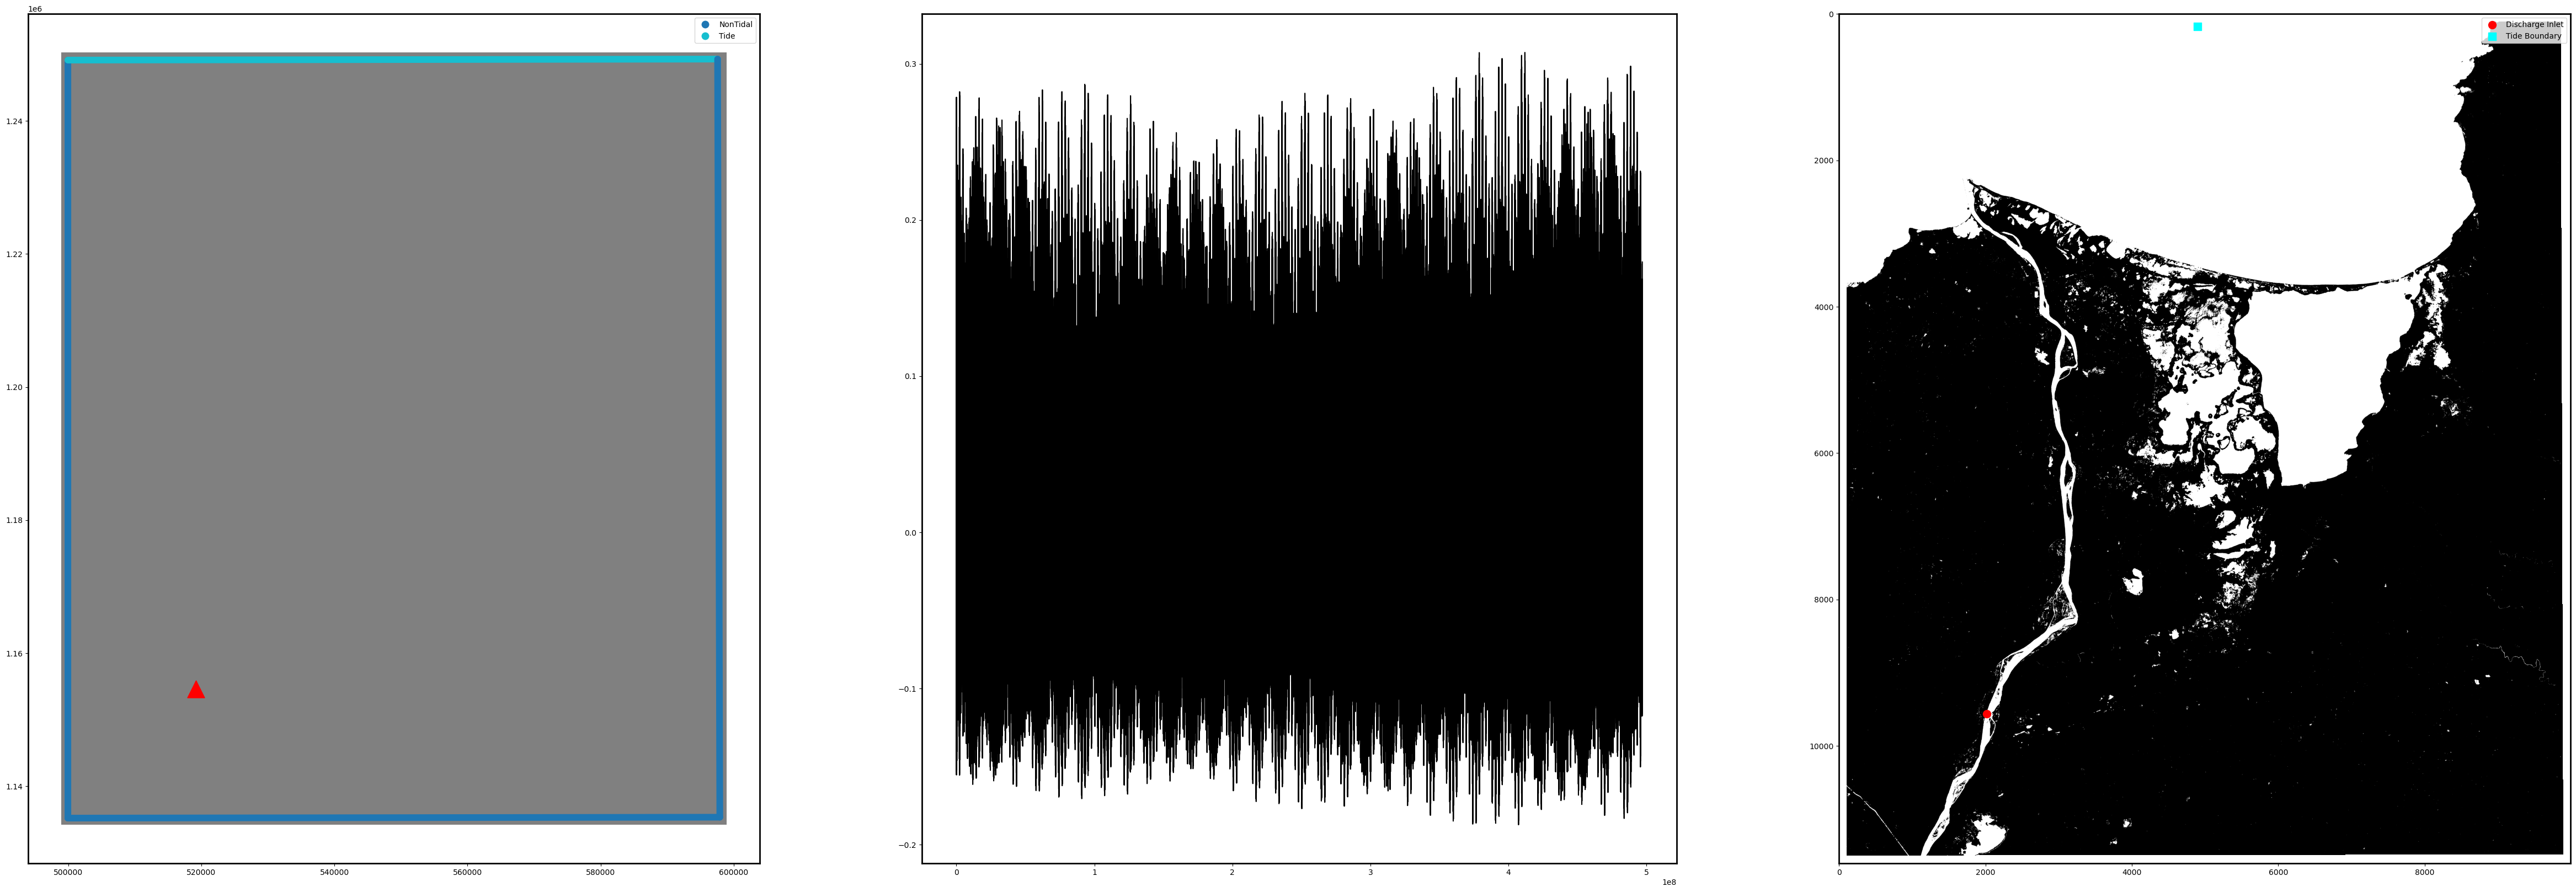

In [25]:

fig,[ax1,ax2,ax3] = plt.subplots(ncols=3,figsize=(60,20))

AOI_extent.plot(ax=ax1,color='grey',legend = True,label='model domain')
boundary_segments.plot(ax=ax1,categorical=True,legend=True,column='boundary')
ax1.scatter(inletLON_EPSG,inletLAT_EPSG,color='red',marker='^',s=500,label='Inlet')

ax2.plot(tide_data[:,0],tide_data[:,1],'black')

ax3.imshow(masked[0],'gray')
ax3.scatter((inletLON_EPSG-origin_x)/res,(origin_y - inletLAT_EPSG)/res, s=100, c='red', marker='o',label='Discharge Inlet')
ax3.scatter((tides.geometry[0].coords[0][0]-origin_x)/res,(origin_y - tides.geometry[0].coords[0][1])/res, s=100, c='cyan', marker='s',label='Tide Boundary')
ax3.legend()

plt.legend()
plt.savefig('%s/%s_model_boundaries_TideLAT%s_TideLON%s_InletLAT%s_InletLON%s.png' %(folders[5],AOI,tideLAT_4326,tideLON_4326,inletLAT_4326,inletLON_4326),dpi=400,bbox_inches='tight')

In [26]:
cleanup = False 
if cleanup == True:
    print('Cleaning up temporary files')
    try:shutil.rmtree(folders[1])
    except:''


<font size=5 color='red'> Done getting boundary conditions. Move on to the next notebook 4_BuildMesh.ipynb </font>
